## Build a model to predict whether a flight will be canceled.

In [132]:
#libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from scipy.stats import f_oneway


In [70]:
#importing data
columns_list = ['Canceled','Month','DepartureTime','UniqueCarrier','SchedElapsedTime',
                'ArrDelay','DepDelay','Distance']
fd = pd.read_csv('Data_Predicting_Flight_Delays.csv', sep = ',', names = columns_list)

In [71]:
#visualizing 
fd.head(20)

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1,12,814,UA,134,0,0,679
1,1,12,830,DL,90,0,0,214
2,1,1,1835,UA,213,0,0,1605
3,1,4,1730,AA,80,0,0,235
4,1,7,1442,UA,103,0,0,413
5,1,2,820,DL,119,0,0,692
6,1,1,1430,DL,70,0,0,214
7,1,4,930,AA,155,0,0,1062
8,1,4,1550,AA,130,0,0,813
9,1,6,1725,DL,118,0,0,533


In [ ]:
#Exploratory Data Analysis - checking for data leakage 

In [5]:
fd.groupby('Canceled')['DepDelay'].mean()

Canceled
0    10.9594
1     0.0960
Name: DepDelay, dtype: float64

In [6]:
fd.groupby('Canceled')['ArrDelay'].mean()

Canceled
0    9.7356
1    0.0000
Name: ArrDelay, dtype: float64

In [7]:
fd.loc[(fd['Canceled'] == 1) & (fd['DepDelay'] > 0)]

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
48,1,12,1844,UA,187,0,46,1197
307,1,12,2240,DL,57,0,13,215
409,1,10,759,UA,281,0,14,1619
540,1,12,1445,AA,60,0,3,190
550,1,12,1055,DL,158,0,41,950


In [ ]:
#given we can see from the above EDA that both DepDelay and ArrDelay are 0 almost across the board for Canceled == 1 
#flights, these are removed to reduce data leakage 

fd.drop(['ArrDelay', 'DepDelay'], axis = 1, inplace = True)
fd.head()

In [10]:
#examine if there is any missing data that we should work on imputing 

fd.isna().sum()

#good from a missing data standpoint 

Canceled            0
Month               0
DepartureTime       0
UniqueCarrier       0
SchedElapsedTime    0
Distance            0
dtype: int64

In [ ]:
#checking for outliers 

def find_outliers(df, columns):
    desc = df[columns].describe().reset_index() 

    iqrs = []
    outliers = []
    for x in range(len(columns)):
        q3 = desc.iloc[6, x + 1]
        q1 = desc.iloc[4, x + 1]
        iqr = (desc.iloc[6, x + 1] - desc.iloc[4, x + 1]) * 1.5
        iqrs.append([columns[x], iqr])
        print(iqrs[x][1])
        outliers.append([columns[x], [g for g in df[columns].iloc[:,x] if (g > q3 + iqrs[x][1]) | (g < q1 - iqrs[x][1])]])
                
    return outliers
        
find_outliers(fd, ['Distance','SchedElapsedTime','Month'])

#from these results we can verify there are a few outliers that immediately jump out in the data, however only
# a few of the >4000 values for Distance and >500 values for SchedElapsedTime really jump out, 
# and these might be important predictors for identifying the minor class cancelled flights later on, so keeping these for now

(array([  3.,  45., 144., 215., 175., 154., 176., 191., 165.,  82., 243.,
        286., 271., 182., 306., 190., 157., 176., 218., 203., 152., 123.,
        148., 140.,  95., 184.,  97.,  39.,  23.,  80.,  76.,  85.,  46.,
         68., 100.,  38.,  26., 173.,  28.,  15.,  65.,  49.,  38.,  11.,
          8.,  27.,  17.,  44.,   7.,  17.,  42.,  37.,  16.,  54.,  83.,
          8.,  69.,  31.,   0.,  20.,   0.,   0.,   1.,   0.,   0.,   5.,
          0.,   4.,   2.,   0.,   0.,   0.,   1.,   0.,   4.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   6.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   3.,   0.,   0.,   0.,   0.,
          8.]),
 array([  68.  ,  112.34,  156.68,  201.02,  245.36,  289.7 ,  334.04,
         378.38,  422.72,  467.06,  511.4 ,  555.74,  600.08,  644.42,
         688.76,  733.1 ,  777.44,  821.78,  866.12,  910.46,  954.8 ,
         999.14, 1043.48, 1087.82, 1132.16, 1176.5 , 1220.84, 1265.18,
        1309.52, 1353.86, 1398.2 ,

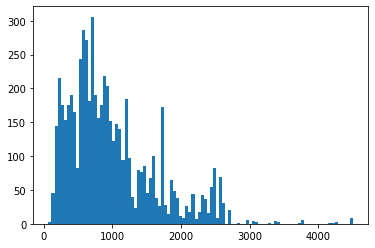

In [133]:
#visualizing Distance outliers 
plt.hist(fd['Distance'], bins = 100)

In [77]:
#creating function to extract departing hourtime 

def extract_hour(hour):
    hour = str(hour)
    if len(hour) <= 2:
        return 0
    elif len(hour) == 3:
        return int(hour[0])
    else:
        return int(hour[:2])

fd['Hourtime'] = fd['DepartureTime'].apply(lambda x: extract_hour(x))

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hourtime
0,1,12,814,UA,134,0,0,679,8
1,1,12,830,DL,90,0,0,214,8
2,1,1,1835,UA,213,0,0,1605,18
3,1,4,1730,AA,80,0,0,235,17
4,1,7,1442,UA,103,0,0,413,14
...,...,...,...,...,...,...,...,...,...
5995,0,6,1725,AA,115,17,30,597,17
5996,0,9,1945,DL,127,-19,-9,752,19
5997,0,8,1850,DL,101,6,-4,481,18
5998,0,7,1720,AA,210,178,42,1302,17


In [82]:
fd[fd['Hourtime'] == 0]

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hourtime
1971,0,3,55,DL,157,-4,-3,1199,0
2020,0,6,50,DL,231,-32,-3,1678,0
2113,0,1,40,AA,170,-14,-9,1235,0
2626,0,3,5,UA,251,17,35,1956,0
2850,0,4,55,DL,254,-1,15,1946,0
3979,0,1,55,DL,158,-11,-12,1199,0
4277,0,1,30,DL,218,-9,-4,1589,0
4316,0,6,30,DL,227,-29,0,1589,0
4608,0,7,35,AA,210,-6,3,1515,0
4758,0,10,10,AA,165,6,2,1235,0


In [ ]:
#comparing results from our function to more manual way of finding outliers for the Distance variable
iqr1 = stats.iqr(fd['Distance']) * 1.5
q1, q3 = fd['Distance'].quantile([0.25, 0.75])
print(q1, q3, iqr1)
print([g for g in fd['Distance'] if (g > q3 + iqr1) | (g < q1 - iqr1)])

In [ ]:
#Feature Engineering 

In [98]:
#creating new variable time to extract more information from DepartureTime variables 

fd['time'] = np.where((fd['DepartureTime'] >= 200) & (fd['DepartureTime'] < 700), 'aube', 
                     np.where((fd['DepartureTime'] >= 700) & (fd['DepartureTime'] < 1000), 'earlymorning',
                     np.where((fd['DepartureTime'] >= 1000) & (fd['DepartureTime'] < 1200), 'latemorning',
                     np.where((fd['DepartureTime'] >= 1200) & (fd['DepartureTime'] < 1500), 'earlyafternoon',
                     np.where((fd['DepartureTime'] >= 1500) & (fd['DepartureTime'] < 1900), 'lateafternoon',
                      np.where((fd['DepartureTime'] >= 1900) & (fd['DepartureTime'] < 2200), 'dinnertime', 
                      np.where((fd['DepartureTime'] >= 2200) | (fd['DepartureTime'] < 200), 'earlymorning', 'nothing')))))))


#creating dummies for UniqueCarrier and time variables to be able to use in linear regression model 

fd = pd.get_dummies(fd, drop_first = True)


<AxesSubplot:>

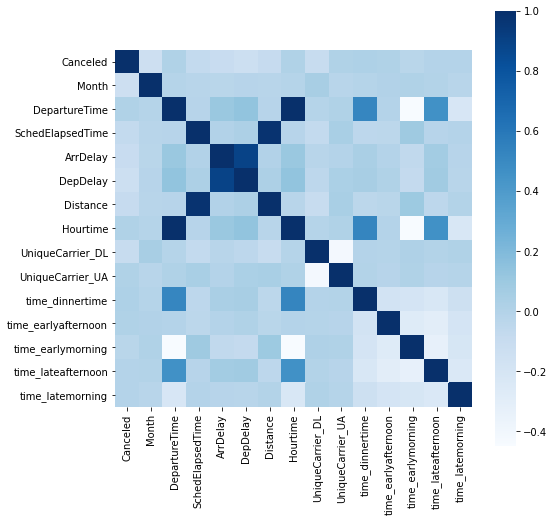

In [104]:
#looking at correlations in data 
data = fd.select_dtypes(include = ['int64','float64','uint8']).corr()
plt.figure(figsize = (8,8))
sns.heatmap(data = data, square = True, cmap = 'Blues')

In [ ]:
#little correlation between our variables indicates there is a relative paucity of linear relationships in this 
#dataset such that Logistic Regression, which is a linear model by nature, might not be the best model 
#for this dataset. However, we should still investigate Logistic Regression and look at a tree-based model 
#such as RandomForest Classifier and XGBoostClassifier. 

#### LogisticRegression 

In [112]:
#setting weights to correct class imbalance when training model 
w = {0: 1000, 1: 5000}
lr = LogisticRegressionCV(cv = 5, class_weight = w, max_iter = 300)


#splitting data
x = fd.drop(['Canceled'], axis = 1)
y = fd['Canceled']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((4020, 12), (1980, 12), (4020,), (1980,))

In [8]:
lr.fit(x_train, y_train)

LogisticRegressionCV(class_weight={0: 1000, 1: 5000}, cv=5, max_iter=300)

In [9]:
lr.score(x_test, y_test)

0.6292929292929293

In [68]:
cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'roc_auc')

array([0.67609967, 0.6624052 , 0.63496656, 0.53725137, 0.73025977])

In [69]:
cross_val_score(lr, x_test, y_test, cv = 5, scoring = 'roc_auc').mean()

#given our Logistic Regression model does not perform very well on this data, turning to tree ensembling methods 
#to try and get better results 

0.6481965169193911

In [113]:
#RandomForestsClassifier 
rfc = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 4, class_weight = {0:1, 1:5})
rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=4)

In [114]:
rfc.score(x_train, y_train)

0.6748756218905473

In [115]:
rfc.score(x_test, y_test)

0.6621212121212121

In [35]:
cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'roc_auc')

array([0.7027519 , 0.68125677, 0.67504715, 0.5727452 , 0.71045525])

In [77]:
cross_val_score(rfc, x_test, y_test, cv = 5, scoring = 'roc_auc').mean()

#able to slightly improve classification accuracy by 2pts using RandomForests, but not much better 

0.6692499788219664

In [10]:
#trying XGBoost to try to get better results 

xgb = XGBClassifier(scale_pos_weight=100, n_estimators = 300)
xgb.fit(x_train, y_train)
cross_val_score(xgb, x_test, y_test, scoring = 'roc_auc', cv = 5)


array([0.67406284, 0.66184182, 0.61096108, 0.54475309, 0.68164866])

In [11]:
cross_val_score(xgb, x_test, y_test, scoring = 'roc_auc', cv = 5).mean()

0.6346534969020624

In [ ]:
#XGB yields worst results than RandomForestClassifier

<AxesSubplot:>

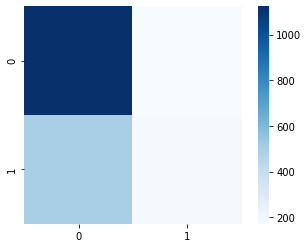

In [118]:
#looking at relative strengths of our model 

rfc_predictions = rfc.predict(x_test)
cm_rfc = confusion_matrix(rfc_predictions, y_test)
sns.heatmap(cm_rfc, cmap = 'Blues', square = True)

In [123]:
print(cm_rfc)
print("RF_pred:", f1_score(y_test,rfc_predictions))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rfc_predictions)
#even adjusting for the class imbalance with class weights we can see that our model is still relatively poor 
# at predicting cancelled flights 

[[1124  171]
 [ 498  187]]
RF_pred: 0.35858101629913713


In [128]:
print(fpr_rf, tpr_rf, _)

[0.         0.30702836 1.        ] [0.         0.52234637 1.        ] [2 1 0]


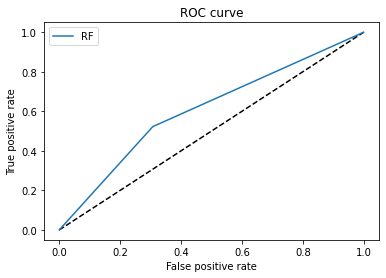

In [131]:
#visualizing ROC curve for our RandomForestClassifier model 
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Provide recommendation on which airline is most reliable.

In [17]:
#splitting data by airline to perform anova test 

fd2 = pd.read_csv('Data_Predicting_Flight_Delays.csv', sep = ',', names = columns_list)

In [19]:
fd2.groupby('UniqueCarrier')['Canceled'].mean().reset_index() 
#initial investigation shows DL appears to be most reliable, but additional 
#statistical tests including one way anova and two sample t tests are needed to ascertain this 

,UniqueCarrier,Canceled
0,AA,0.199111
1,DL,0.111967
2,UA,0.173203


In [15]:
fd2.UniqueCarrier.unique()

array(['UA', 'DL', 'AA'], dtype=object)

In [21]:
UAdf = fd2.loc[fd2['UniqueCarrier'] == 'UA']['Canceled']
DLdf = fd2.loc[fd2['UniqueCarrier'] == 'DL']['Canceled']
AAdf = fd2.loc[fd2['UniqueCarrier'] == 'AA']['Canceled']

3       1
7       1
8       1
10      1
11      1
       ..
5990    0
5994    0
5995    0
5998    0
5999    0
Name: Canceled, Length: 2476, dtype: int64

In [22]:

f_oneway(UAdf, DLdf, AAdf)
#able to see that we can reject the null hypothesis that are means are equal 

F_onewayResult(statistic=28.094481906711394, pvalue=7.170129477576311e-13)

In [23]:
stats.ttest_ind(UAdf,DLdf)

Ttest_indResult(statistic=5.192625548418433, pvalue=2.190950774899341e-07)

In [24]:
stats.ttest_ind(AAdf,DLdf)

Ttest_indResult(statistic=7.508766664457165, pvalue=7.260467076950107e-14)

In [36]:

confusion_matrix(rfc.predict(x_test), y_test)

array([[1117,  158],
       [ 505,  200]])

In [31]:
confusion_matrix(xgb.predict(x_test), y_test)

array([[1207,  201],
       [ 415,  157]])

In [30]:
confusion_matrix(lr.predict(x_test), y_test)

array([[1038,  150],
       [ 584,  208]])

In [ ]:
#we can reject the null hypothesis from these two sample t tests that AAL and UAL 
#mean cancelation rates are identical to those of DAL, and can confidently recommend
#DAL as the most reliable airline from a cancelation perspective 